In [52]:
import time
import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.preprocessing import MinMaxScaler

        
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau


/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


In [65]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [66]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
def convert_categorical(category, df):
    s = str(category)
    df = pd.get_dummies(df, columns=[s])
    return df

def encode_df(df):
    
    df_encoded = convert_categorical('cp_type', df)
    df_encoded1 = convert_categorical('cp_dose', df_encoded)
    return(df_encoded1)

train_features_encoded = encode_df(train_features)

if 'cp_dose_D1'and'cp_type_trt_cp' in train_features_encoded.columns:
    print("encoded columns successfully")
else:
    print("Nope")

encoded columns successfully


In [23]:
train_features_encoded.shape, train_targets_scored.shape


((23814, 878), (23814, 207))

In [25]:
train_cat = train_features_encoded.merge(train_targets_scored, on='sig_id')


In [26]:
dummy_df = train_cat.loc[:, train_cat.columns != 'sig_id']
df_float = dummy_df.astype(float)
scaler = MinMaxScaler()
df_float_scaled = pd.DataFrame(scaler.fit_transform(df_float), columns = df_float.columns)
df_float_scaled['sig_id'] = train_features_encoded['sig_id']
df_float_scaled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 1084 entries, cp_time to sig_id
dtypes: float64(1083), object(1)
memory usage: 196.9+ MB


In [27]:
class TrainDataset(Dataset):
    def __init__(self, df, feature_columns, target_columns):
        
        self.features  = df[feature_columns].values
        self.targets = df[target_columns].values
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float()
        target = torch.tensor(self.targets[idx]).float()
        
        return feature,target

In [28]:
full_dataset = TrainDataset(df_float_scaled, feature_columns, target_columns)

In [29]:
full_dataset.sizes()

features size =  877
targets size =  206


In [79]:
train_size = int(0.9 * len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers = 8)

val_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle = True, num_workers = 8)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

1340 batches 
38  batches 


In [153]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(877, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 2048)
        self.fc5 = nn.Linear(2048, 2048)

        self.fc6 = nn.Linear(2048, 1024)

        self.fc7 = nn.Linear(1024, 512)
        self.fc8 = nn.Linear(512, 206)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        x = self.dropout(F.relu(self.fc6(x)))


        x = F.relu(self.fc7(x))

        return torch.sigmoid(self.fc8(x))
    
model = Model()
print(model)
model = model.cuda()

Model(
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=877, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (fc5): Linear(in_features=2048, out_features=2048, bias=True)
  (fc6): Linear(in_features=2048, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=512, bias=True)
  (fc8): Linear(in_features=512, out_features=206, bias=True)
)


In [154]:
inp, label = next(iter(train_loader))

In [155]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm

from torch.optim.lr_scheduler import ReduceLROnPlateau



def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()
    
def show_deltas(deltas):
    deltas = gaussian_filter1d(deltas, sigma=3)
    plt.plot(deltas, "r", label = "Absolute error from label ")
    plt.ylabel("Error", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

In [156]:

def train_step(x, y, model, optimizer, criterion):
        optimizer.zero_grad()
        pred = model(x)
        y = y.float()
        loss = criterion(pred,y)
        loss.backward()
        optimizer.step()
        return loss.item()
    
    
def train_step(x, y, model, optimizer, criterion):
        optimizer.zero_grad()
        pred = model(x.cuda())
        y = y.float()
        loss = criterion(pred,y)
        loss.backward()
        optimizer.step()
        return loss.item()


def train_model(config):

    epochs = config["epochs"]
    model = config["model"]
    train_loder = config["train_loader"]
    val_loader = config["val_loader"]
    optimizer = config["optimizer"]
    scheduler = config["scheduler"]
    criterion = config["loss_function"]

    start = time.process_time()
    losses = []
    val_losses = []
    learning_rates = []
    average_deltas = []

    for m in range (epochs):
        clear_output(wait = True)
        show_lr(learning_rates)
        show_deltas(average_deltas)
        
        plt.plot(val_losses, label = "val_losses")
        plt.legend()
        plt.show()
        
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            model.eval()

            for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):

                yhat =model(x_val.cuda())  # pred 
                val_loss = criterion(yhat.cuda(), y_val.cuda())
                val_losses.append(val_loss.item())  ## metrics 

                average_deltas.append(torch.mean(torch.abs(yhat.cpu()-y_val.cpu())).item())


        model.train()
       
        for batch in tqdm(train_loader, desc = " Training batches : "):
           
            (x_batch, y_batch) = batch

            loss = train_step(x_batch, y_batch.cuda(), model, optimizer, criterion)
            losses.append(loss)
        scheduler.step(1.)   ## lr decay caller 
        learning_rates.append(get_lr(optimizer))
        

    clear_output(wait = True)

    show_lr(learning_rates)
    show_deltas(average_deltas)

    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    
    return val_losses
    

In [157]:
optimizer = optim.Adam(model.parameters(), lr = 0.003) 

scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.5, 
                                patience=8, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0, 
                                eps=1e-08)

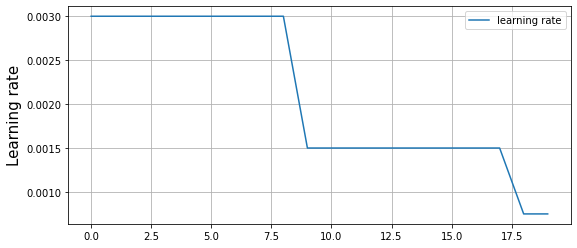

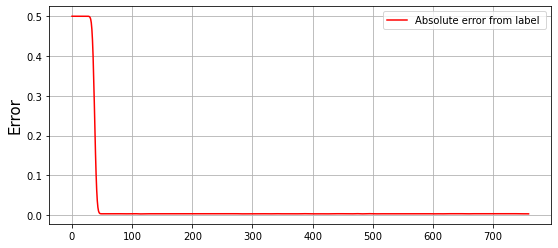

Time elapsed =  230.08446936400014  seconds


In [158]:

plt.rcParams["figure.figsize"] = (9,4)

config = { 
        "epochs" : 20,    
        "model" : model,      
        "train_loader" : train_loader, 
        "val_loader" : val_loader,
        "optimizer" : optimizer,
        "scheduler" : scheduler,
        "loss_function" : nn.BCELoss()
        }
losses = train_model(config)

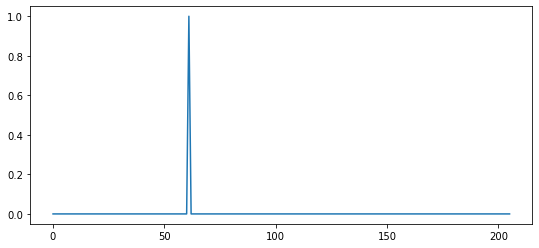

In [163]:
inp, labels = next(iter(train_loader))
plt.plot(labels[0])

In [164]:
pred = model(inp.cuda())

SyntaxError: unexpected EOF while parsing (<ipython-input-164-3da5048baa64>, line 1)

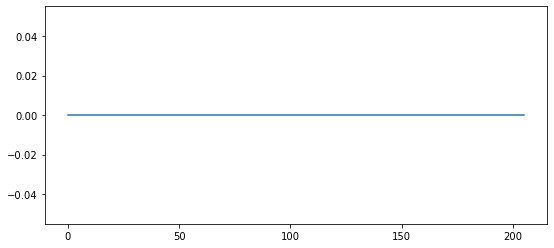

In [165]:
plt.plot(pred[0].cpu().detach())